<a href="https://colab.research.google.com/github/Baldros/NLP-Course-HuggingFace/blob/main/3.1.%20Processando_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação:

    O processamento de dados é uma etapa fundamental do processo
    de construção de uma Inteligência Artificial e precisa-se ter
    certo dominio no tópico, sobre tudo quando o assunto é NLP.

    O objetivo desse tópico é justamente aprofundar um pouco mais
    nas questões de processamento dos dados e começaremos aqui
    voltando num dos exemplos do primeiro capítulo do curso.

# Contextualização do modelo utilizado:

**BERT - Bidirectional Encoder Representations from Transformers**

    BERT é um modelo de transformadores pré-treinado em um grande corpus
    de dados em inglês de maneira auto-supervisionada. Isso significa que
    ele foi pré-treinado apenas nos textos brutos, sem nenhum tipo de
    rotulação humana (o que é por que ele pode usar muitos dados disponíveis
    publicamente) com um processo automático para gerar entradas e rótulos
    a partir desses textos.

**Objetivos:**

    Mais precisamente, ele foi pré-treinado com dois objetivos:

    1. Modelagem de linguagem mascarada (MLM): pegando uma sentença, o modelo
    aleatoriamente mascara 15% das palavras na entrada, então executa a
    sentença mascarada inteira pelo modelo e tem que prever as palavras
    mascaradas. Isso é diferente das redes neurais recorrentes (RNNs)
    tradicionais que geralmente veem as palavras uma após a outra, ou de
    modelos autorregressivos como GPT que internamente mascaram os tokens
    futuros. Isso permite que o modelo aprenda uma representação bidirecional
    da sentença.

    2. Previsão da próxima sentença (NSP): o modelo concatena duas sentenças
    mascaradas como entradas durante o pré-treinamento. Às vezes, elas
    correspondem a sentenças que estavam uma ao lado da outra no texto
    original, às vezes não. O modelo então tem que prever se as duas
    sentenças estavam seguindo uma à outra ou não.

    Ou seja, o BERT base é capaz de aprender uma representação interna
    da língua inglesa que pode ser usada para extrair características
    úteis para uma variedade de tarefas downstream, como classificação
    de texto, análise de sentimento, resposta a perguntas, entre outras.
    Ele é particularmente eficaz devido à sua capacidade de entender o
    contexto bidirecional das palavras em uma frase.

Fonte: https://huggingface.co/google-bert/bert-base-uncased

OBS:

    O "uncased" do nome do modelo, significa que ele não faz distinção
    entre letras maúsculas e minúsculas, como em "nome", "NOME", por
    exemplo. Acho isso importante de se ressaltar, inclusive para o
    melhr entendimento do modelo.

Entendendo um pouco mais do modelo:

1. Experimentações: https://huggingface.co/spaces/exbert-project/exbert

2. Artigo: https://arxiv.org/pdf/1810.04805.pdf

    Aqui utilizaremos o modelo para checar similaridade entre sentenças.
    entender isso é muito importante para entender como os elementos aqui
    irão funcionar.

In [159]:
# Checkpoint:
checkpoint = "bert-base-uncased"

# Entradas:
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]

In [160]:
# Importando a classe de tokenização:
from transformers import AutoTokenizer

In [161]:
# Instanciando tokenizador:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

**Pytorch**

In [162]:
# Importando Dependências:
import torch
from transformers import AdamW, AutoModelForSequenceClassification

# Instanciando elementos:
model_pt = AutoModelForSequenceClassification.from_pretrained(checkpoint)
batch_pt = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    Note que a própria biblioteca já alertou que os pesos não
    foram inicializados com o modelo e já sugere um trainamento,
    ou seja, no nosso caso, um fine-tuning para que o modelo
    possa funcionar adequadamete.

    Ou seja, a questão de comparar os modelos pos e pré fine-tuning
    pode ser que nem se dê pra fazer, porque pode ser que o modelo
    nem consiga ser executado sem o fine-tuning.

    O que daria pra fazer é pegar esse modelo fine-tunado com a menor
    quantidade de entradas possiveis e testar com fine-tunado com mais
    entradas. Obviamente o modelo com mais entradas vai funcionar melhor,
    mas dá pra tendar fazer algum teste de performance.

In [163]:
# Adicionando novo de rótulos:
batch_pt["labels"] = torch.tensor([1, 1])

# Fine-tuning do modelo:
optimizer = AdamW(model_pt.parameters()) # Inicializa o otimizador AdamW (descontinuada) com os parâmetros do modelo
loss = model_pt(**batch_pt).loss # Calculando a perda do modelo para o lote de dados (batch) fornecidos
loss.backward() # calculando os gradientes dos pesos do modelo com relação à perda
optimizer.step() # atualizando os pesos do modelo

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Tensorflow**

In [164]:
# Dependencias importantes:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Instanciando elemetos:
model_tf = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
batch_tf = dict(tokenizer(sequences, padding=True, truncation=True, return_tensors="tf")) # Note a diferença

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [165]:
# Fine-tuning do modelo:
model_tf.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
labels = tf.convert_to_tensor([1, 1])
model_tf.train_on_batch(batch_tf, labels)

4.172324281626061e-07

**Conclusão**

    É claro, apenas treinar o modelo em duas frases não vai produzir
    resultados muito bons. Para obter melhores resultados, você precisará
    preparar um conjunto de dados maior.

**Nota**

    Apesar de executarem o mesmo procedimento, o processo de fine-tuning
    entre as duas bibliotecas, pytorch e tensorflow, é bem diferente. Mudando
    até a ordem de execução das coisas.

# Datasets para fine-tuning de modelos:

    O Hub da Hugging Face não contém apenas modelos; ele também possui vários
    conjuntos de dados em muitos idiomas diferentes. Você pode navegar pelos
    conjuntos de dados aqui, e recomendamos que você tente carregar e processar
    um novo conjunto de dados assim que terminar esta seção (consulte a
    documentação geral aqui). Mas por enquanto, vamos nos concentrar no
    conjunto de dados MRPC! Este é um dos 10 conjuntos de dados que compõem o
    benchmark GLUE, que é um benchmark acadêmico usado para medir o desempenho
    de modelos de ML em 10 tarefas diferentes de classificação de texto.

In [166]:
# Instantando os datasets:
!pip install datasets

In [167]:
# Importando dataset:
from datasets import load_dataset

In [168]:
# Definindo os dataset:
raw_datasets = load_dataset("glue", "mrpc");raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

    Este comando faz o download e armazena em cache o conjunto de dados,
    por padrão em ~/.cache/huggingface/datasets. Lembre-se do Capítulo 2
    que você pode personalizar sua pasta de cache definindo a variável de
    ambiente HF_HOME.

In [169]:
# Extraindo informações:
qtd_dados = [raw_datasets[key].num_rows for key in raw_datasets.keys()]
qtd_features = list(raw_datasets['train'].features.keys()) # Todos os outros conjuntos repetiram o modelo do treino
names = list(raw_datasets.keys())

# Printando informação:
print(
    f'''
\033[1mNote:\033[0m

    Como podemos ver, obtemos um objeto DatasetDict que contém o
    conjunto de \033[1m{names[0]}\033[0m, o conjunto de \033[1m{names[1]}\033[0m e o conjunto de \033[1m{names[2]}\033[0m.
    Cada um deles contém várias colunas (\033[1m{qtd_features[0]}\033[0m, \033[1m{qtd_features[1]}\033[0m, \033[1m{qtd_features[2]}\033[0m e \033[1m{qtd_features[3]}\033[0m)
    e um número variável de linhas, que são o número de elementos em cada
    conjunto (portanto, existem \033[1m{qtd_dados[0]}\033[0m pares de frases no conjunto de
    treinamento, \033[1m{qtd_dados[1]}\033[0m no conjunto de validação e \033[1m{qtd_dados[2]}\033[0m no
    conjunto de teste).
    ''')


Note:

    Como podemos ver, obtemos um objeto DatasetDict que contém o
    conjunto de train, o conjunto de validation e o conjunto de test.
    Cada um deles contém várias colunas (sentence1, sentence2, label e idx)
    e um número variável de linhas, que são o número de elementos em cada
    conjunto (portanto, existem 3668 pares de frases no conjunto de
    treinamento, 408 no conjunto de validação e 1725 no
    conjunto de teste).
    


    Dito isso, podemos acessar o cada par de sentenças do nosso conjunto
    de dados para checar e para isso, basta saber como um dicionário funciona.

In [170]:
raw_datasets["train"][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

In [171]:
# Checando mais informações:
for i in range(10):
  print(f'Sentenças da idx {i}')
  print(f"1º {raw_datasets['train'][i]['sentence1']}")
  print(f"2º: {raw_datasets['train'][i]['sentence2']}")
  print()

Sentenças da idx 0
1º Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
2º: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

Sentenças da idx 1
1º Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .
2º: Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

Sentenças da idx 2
1º They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .
2º: On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .

Sentenças da idx 3
1º Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .
2º: Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .

Sentenças da idx 4
1º The stock rose $ 2.11 , or about 11

**Importante**

    Eu gostaria de pontuar um detalhe que não exatamente muda alguma coisa
    aqui, mas que eu acho importante notar... Note que o dado está labelado,
    ou seja, aqui nos temos uma situação de aprendizado supervisionado. Em seu
    livro, Build a Large Language Model (From Scratch), o autor, Sebastian
    Raschka explica que (Imagem abaixo):


In [172]:
# Baixando a imagem do livro:
!curl -o img.png https://drek4537l1klr.cloudfront.net/raschka/v-5/Figures/01__image005.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40099  100 40099    0     0  95328      0 --:--:-- --:--:-- --:--:-- 95247


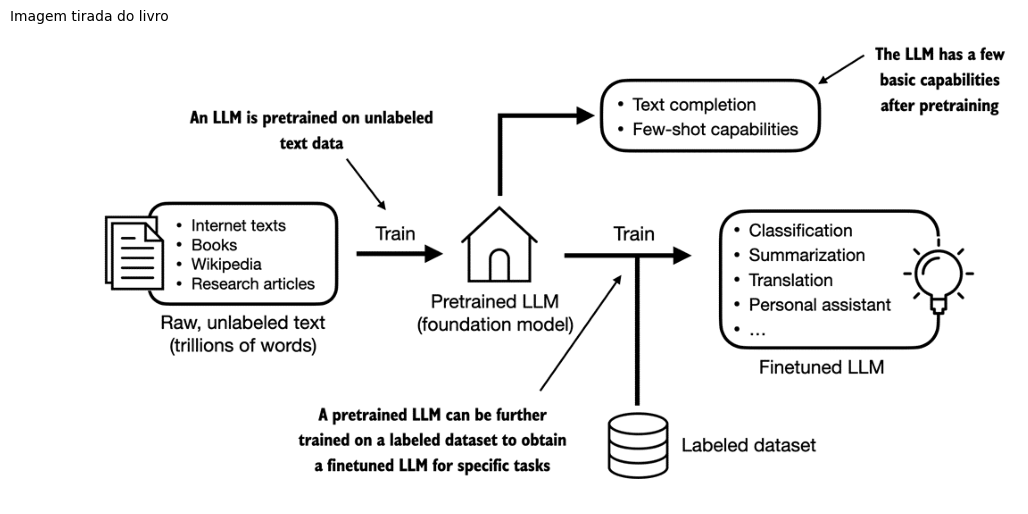

In [173]:
# Importando biblioteca para visualização:
import cv2
from matplotlib import pyplot as plt

# Carregar a imagem:
imagem = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)

# Verificar se a imagem foi carregada corretamente
if imagem is None:
    print("Erro ao carregar a imagem. Verifique o caminho da imagem.")
else:
    # Mostrar a imagem usando matplotlib
    plt.figure(figsize=(12,12))
    plt.imshow(imagem, cmap='gray')
    plt.text(0.5, 0.5, 'Imagem tirada do livro', ha='center')
    plt.axis('off')
    plt.show()

    Ou seja, note que o primeiro treinamento do modelo, chamado pelo autor de
    "modelo fundamental" ou "modelo base", é feito de forma não supervisionada!
    (no caso do BERT eles dizem que é feito de forma "auto-supervisionada")
    Mas o fine-tuning de fato é feito de forma supervisionada, como mostra no
    livro. Ou seja, de fato estamos indo de acordo com a literatura vigente.

Dito isso:

    Podemos ver que os rótulos já são inteiros, então não precisaremos fazer
    nenhum pré-processamento lá. Para saber qual inteiro corresponde a qual
    rótulo, podemos inspecionar as características do nosso raw_train_dataset.
    Isso nos dirá o tipo de cada coluna:

In [174]:
raw_datasets["train"].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

    Nos bastidores, o rótulo é do tipo ClassLabel, e o mapeamento de
    inteiros para o nome do rótulo é armazenado na pasta names. O 0
    corresponde a not_equivalent, e o 1 corresponde a equivalent.

# Pré-processando o Dataset:

    Pré-processar o conjunto de dados, nada mais é que converter o texto
    em números para que o modelo possa entender. Como você vimos no capítulo
    anterior, isso é feito com um tokenizador. Podemos fornecer ao tokenizador
    uma sentença ou uma lista de sentenças, então podemos tokenizar diretamente
    todas as primeiras sentenças e todas as segundas sentenças de cada par dessa forma:

Nota:

    Vimos também que o tokenizador utilizado aqui será o mesmo tanto
    pytorch quanto para o tensorflow, o que é de grande ajuda.

In [175]:
# Importando o tokenizador:
from transformers import AutoTokenizer

OBS:

    A classe AutoTokenizer instancia o tokenizer especificado pelo método
    from_pretrained() para cada modelo. Estou pontuando isso só para dizer
    que esse tokenizador pode ser uma Rede Neural ou não, a depender do
    modelo utilizado.

    Nesse caso em específico, o tokenizador aqui não é uma Rede Neural,
    por exemplo, dado que o tokenizador do modelo bert é um método de
    pré-processamento denominado WordPiece.

Fonte: https://huggingface.co/learn/nlp-course/chapter6/6

In [176]:
# Definindo o modelo:
checkpoint = "bert-base-uncased"

# Instanciando o tokenizador:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [177]:
# Codificando as sentenças:
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

    No entanto, não podemos simplesmente passar duas sequências para o modelo
    e obter uma previsão se as duas sentenças são paráfrases ou não. Precisamos
    lidar com as duas sequências como um par e aplicar o pré-processamento
    apropriado. Felizmente, o tokenizador também pode receber um par de
    sequências e prepará-lo da maneira que nosso modelo BERT espera:

In [178]:
# Entrada para o tokenizador:
inputs = tokenizer("This is the first sentence.", "This is the second one.")

# Checando inputs:
for key in inputs.keys():
  if key == 'token_type_ids':
    print(f'{key}:{inputs[key]} # Os zeros são a parte da primeira sentença')
  else:
    print(f'{key}:{inputs[key]}')

input_ids:[101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102]
token_type_ids:[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1] # Os zeros são a parte da primeira sentença
attention_mask:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


token_type_ids:

    Nós discutimos as chaves input_ids e attention_mask no Capítulo 2, mas
    adiamos a discussão sobre token_type_ids. Neste exemplo, é isso que
    informa ao modelo qual parte da entrada é a primeira sentença e qual
    é a segunda sentença.

Decoder:

    Como já vimos também podemos utilizar o decoder para reconstruir a
    mensagem em caracteres.

In [179]:
# Destokenização:
list_msg = tokenizer.convert_ids_to_tokens(inputs["input_ids"]);print(list_msg)

['[CLS]', 'this', 'is', 'the', 'first', 'sentence', '.', '[SEP]', 'this', 'is', 'the', 'second', 'one', '.', '[SEP]']


    Note que temos os tokens especiais, então vemos que o modelo espera que
    as entradas estejam na forma [CLS] sentença1 [SEP] sentença2 [SEP] quando
    há duas sentenças. Alinhando isso com os token_type_ids, temos:

In [180]:
# Imporando pandas para ajudar a visualizar:
import pandas as pd

In [181]:
# Comparando token_type_ids com a mensagem destokenizada:
pd.concat([pd.DataFrame(list_msg, columns=['msg']),pd.DataFrame(inputs["token_type_ids"], columns=['token_type_ids'])],axis=1)

,msg,token_type_ids
0,[CLS],0
1,this,0
2,is,0
3,the,0
4,first,0
5,sentence,0
6,.,0
7,[SEP],0
8,this,1
9,is,1


    Ou seja, aqui estamos vendo que de fato o valor do token_type_ids
    se refere a ou indice da sentença. Show.

**E se eu aumentar o numero de sentenças?**

    Vamos ver abaixo que o modelo só está preparado para lidar com
    a similiaridade entre 2 sentenças apenas, ou seja, se houver a
    necessidade de executar a similaridade entre mais que 2 sentenças,
    vai ter-se que se buscar uma adaptação.

In [182]:
# Tokenizando e convertendo para tokens e token_type_ids para a primeira entrada:
inputs1 = tokenizer("This is the first sentence.", "This is the second one.")
list_msg1 = tokenizer.convert_ids_to_tokens(inputs1["input_ids"])

# Tokenizando e convertendo para tokens e token_type_ids para a segunda entrada:
inputs2 = tokenizer("This is the first sentence.", "This is the second one.","This is the third.","This is the forth.")
list_msg2 = tokenizer.convert_ids_to_tokens(inputs2["input_ids"])

# Construindo DataFrames para cada entrada do tokenizador:
df1 = pd.DataFrame(list_msg1, columns=['msg'])
df1['token_type_ids'] = inputs1['token_type_ids']

df2 = pd.DataFrame(list_msg2, columns=['msg'])
df2['token_type_ids'] = inputs2['token_type_ids']

# Verificando se os DataFrames são diferentes:
print(df1.equals(df2))

True


In [183]:
# Checando a informação das duas tokenizações:
pd.concat([df1,df2],axis=1) # note como não mudas as tabelas:

,msg,token_type_ids,msg,token_type_ids
0,[CLS],0,[CLS],0
1,this,0,this,0
2,is,0,is,0
3,the,0,the,0
4,first,0,first,0
5,sentence,0,sentence,0
6,.,0,.,0
7,[SEP],0,[SEP],0
8,this,1,this,1
9,is,1,is,1


**Conclusão**

    Note que a classe do AutoTokenizer, instanciado na variavel tonkenizer,
    simplesmente ignora as outras sentenças. Isso acontece, porque essa classe
    foi construida para lidar com os tokenizadores de TODOS os modelos, ou seja,
    a classe aceita tudo... E a entrada é tratada, dado o modelo e seu tokenizer
    e a biblioteca transformer simplesmente não comenta nada sobre...

    Ou seja, a ideia aqui é reforçar que o usuário da biblioteca conheça a
    fundo os modelos que ele está utilizando para entender como eles funcionam,
    para conseguir lidar com esse tipo de situação sem perder tempo.

**Como o BERT calcula a similaridade?**

    Mesmo buscando sobre, até mesmo no artigo do modelo, eles não
    explicam exatamente como o BERT calcularia a similaridade entre
    sentenças. O meu palpite é a similaridade de cossenos e é isso
    que eu pretendo textar aqui.

**pytorch**

In [184]:
import numpy as np

In [185]:
# Tokenizando entradas:
inputs_pt= tokenizer("This is the first sentence.", "This is the second one.", return_tensors='pt')

# Realizando a inferência:
outputs_pt = model_pt(**inputs_pt)

# Acessando o vetor semantico, resultado da ultima camada:
embbeding = outputs_pt[0]

print(embbeding) # Ou seja os embbedings

tensor([[-0.5069,  0.1286]], grad_fn=<AddmmBackward0>)


In [186]:
# Importando métrica de similaridade:
from torch.nn.functional import cosine_similarity

# Suponha que `embeddings` seja o tensor que você obteve
embeddings = outputs_pt[0]

# Dividir os embeddings ao meio para obter os embeddings de cada sentença
n = embeddings.shape[1] // 2
first_sentence_embeddings = embeddings[:, :n]
second_sentence_embeddings = embeddings[:, n:]

# Calcular a similaridade de cosseno entre os embeddings das duas sentenças
similarity = cosine_similarity(first_sentence_embeddings, second_sentence_embeddings)

print("Similaridade de cosseno entre as duas sentenças:", similarity.item())

Similaridade de cosseno entre as duas sentenças: -1.0


In [187]:
# Acessando os labels:
model_pt.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

**Tensorflow**

In [188]:
# Tokenizando entradas:
inputs_tf = tokenizer("This is the first sentence.", "This is the second one.", return_tensors='tf')

# Realizando a inferência:
outputs_tf = model_tf(inputs_tf)

# Acessando o vetor semantico, resultado da ultima camada:
print(outputs_tf[0])

tf.Tensor([[-0.24819224  0.7436232 ]], shape=(1, 2), dtype=float32)


In [189]:
# Importando métrica de similaridade:
from sklearn.metrics.pairwise import cosine_similarity

# Acessar os embeddings da última camada oculta
embeddings = outputs_tf[0]

# Separar os embeddings para cada sentença
n = embeddings.shape[1] // 2
first_sentence_embeddings = embeddings[:, :n]
second_sentence_embeddings = embeddings[:, n:]

# Calcular a similaridade de cosseno entre os embeddings das duas sentenças
similarity = cosine_similarity(first_sentence_embeddings.numpy(), second_sentence_embeddings.numpy())

print("Similaridade de cosseno entre as duas sentenças:", similarity.item())

Similaridade de cosseno entre as duas sentenças: -1.0


In [190]:
# Acessando os labels:
model_tf.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

    O método aqui que será utilizado para checar a similaridade de
    sentenças, será o modelo BERT utilizado no método pipeline como
    text-classification.
    
    Provavelmente esse não é o melhor jeito de se testar esse tipo de
    coisa, mas é como eu consigo fazer no momento.

In [191]:
from transformers import pipeline

# Carregue o pipeline de 'text-classification' com 'bert-base-uncased':
text_similarity = pipeline("text-classification", model=checkpoint)

# Calcule a similaridade entre as frases
similarity_score = text_similarity("This is the first sentence.", "This is the second one.")

print("Similaridade entre as frases:", similarity_score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Ignoring args : ('This is the second one.',)


Similaridade entre as frases: [{'label': 'LABEL_1', 'score': 0.5395547151565552}]


**Conclusão**

    Continuamos no escuro sobre como o BERT calcula a similaridade entre
    sentenças, pelo menos por enquanto, pode ser que mais para frente isso
    seja explicado. A conclusão q eu chego é q de fato, ressalvado q o
    pipeline talvez seja limitado para testar isso com mais precisão, de
    fato não parece ser similaridade de cosseno msm não... Pelo menos não
    de forma simple como eu fiz.

Dito isso, voltando ao curso...

    Como podemos ver, as partes da entrada correspondentes a [CLS] sentença1
    [SEP] todas têm um ID de tipo de token 0, enquanto as outras partes,
    correspondentes a sentença2 [SEP], todas têm um ID de tipo de token 1.

    Observe que se você selecionar um ponto de verificação diferente, você não
    necessariamente terá os token_type_ids em suas entradas tokenizadas (por
    exemplo, eles não são retornados se você usar um modelo DistilBERT). Eles
    só são retornados quando o modelo souber o que fazer com eles, porque os
    viu durante seu pré-treinamento.

    Aqui, o BERT é pré-treinado com IDs de tipo de token, e além do objetivo
    de modelagem de linguagem mascarada que discutimos no Capítulo 1, ele tem
    um objetivo adicional chamado previsão de próxima sentença. O objetivo
    dessa tarefa é modelar a relação entre pares de sentenças.

    Com a previsão de próxima sentença, o modelo recebe pares de sentenças
    (com tokens aleatoriamente mascarados) e é solicitado a prever se a segunda
    sentença segue a primeira. Para tornar a tarefa não trivial, metade do
    tempo as sentenças se seguem no documento original de onde foram extraídas,
    e a outra metade do tempo as duas sentenças vêm de dois documentos diferentes.

    Em geral, não precisamos nos preocupar se há ou não token_type_ids em suas
    entradas tokenizadas: desde que você use o mesmo ponto de verificação para
    o tokenizador e o modelo, tudo ficará bem, pois o tokenizador sabe o que
    fornecer ao seu modelo.

    Agora que vimos como nosso tokenizador pode lidar com um par de sentenças,
    podemos usá-lo para tokenizar todo o nosso conjunto de dados: como no
    capítulo anterior, podemos alimentar o tokenizador com uma lista de pares
    de sentenças, fornecendo-lhe a lista de primeiras sentenças e depois a
    lista de segundas sentenças. Isso também é compatível com as opções de
    preenchimento e truncamento que vimos no Capítulo 2. Portanto, uma maneira
    de pré-processar o conjunto de dados de treinamento é:

In [192]:
# Dataset tokenizado
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
)

    Isso funciona bem, mas tem a desvantagem de retornar um dicionário
    (com nossas chaves, input_ids, attention_mask e token_type_ids, e
    valores que são listas de listas). Também só funcionará se você tiver
    memória RAM suficiente para armazenar todo o seu conjunto de dados
    durante a tokenização (enquanto os conjuntos de dados da biblioteca 🤗
    Datasets são arquivos Apache Arrow armazenados no disco, então você só
    mantém as amostras que solicita carregadas na memória).

    Para manter os dados como um conjunto de dados, usaremos o método
    Dataset map(). Isso também nos permite alguma flexibilidade adicional,
    se precisarmos de mais pré-processamento do que apenas a tokenização.
    O método map() funciona aplicando uma função em cada elemento do conjunto
    de dados, então vamos definir uma função que tokeniza nossas entradas:

In [193]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

    Esta função recebe um dicionário (como os itens do nosso conjunto de dados)
    e retorna um novo dicionário com as chaves input_ids, attention_mask e
    token_type_ids. Observe que também funciona se o dicionário de exemplo
    contiver várias amostras (cada chave como uma lista de sentenças), já
    que o tokenizador funciona em listas de pares de sentenças, como visto
    anteriormente. Isso nos permitirá usar a opção batched=True em nossa
    chamada para map(), o que acelerará muito a tokenização. O tokenizador
    é suportado por um tokenizador escrito em Rust da biblioteca 🤗 Tokenizers.
    Este tokenizador pode ser muito rápido, mas apenas se dermos muitas entradas de uma vez.

    Observe que deixamos o argumento de preenchimento de fora em nossa função
    de tokenização por enquanto. Isso ocorre porque preencher todas as amostras
    até o comprimento máximo não é eficiente: é melhor preencher as amostras ao
    construir um lote, pois então só precisamos preencher até o comprimento
    máximo nesse lote e não o comprimento máximo em todo o conjunto de dados.
    Isso pode economizar muito tempo e poder de processamento quando as
    entradas têm comprimentos muito variáveis!

    Aqui está como aplicamos a função de tokenização em todos os nossos
    conjuntos de dados de uma vez. Estamos usando batched=True em nossa
    chamada para map para que a função seja aplicada a vários elementos de
    nosso conjunto de dados de uma vez, e não em cada elemento separadamente.
    Isso permite um pré-processamento mais rápido.

In [194]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

    Você até pode usar o multiprocessing ao aplicar sua função de
    pré-processamento com map() passando um argumento num_proc. Não
    fizemos isso aqui porque a biblioteca 🤗 Tokenizers já usa vários
    threads para tokenizar nossas amostras mais rapidamente, mas se você
    não estiver usando um tokenizador rápido suportado por esta biblioteca,
    isso poderia acelerar seu pré-processamento.

    Nossa função tokenize_function retorna um dicionário com as chaves
    input_ids, attention_mask e token_type_ids, então esses três campos
    são adicionados a todos os splits do nosso conjunto de dados. Observe
    que também poderíamos ter alterado campos existentes se nossa função
    de pré-processamento retornasse um novo valor para uma chave existente
    no conjunto de dados ao qual aplicamos map().

    A última coisa que precisaremos fazer é preencher todos os exemplos até
    o comprimento do elemento mais longo quando agrupamos elementos juntos,
    uma técnica que chamamos de preenchimento dinâmico.

## Testando o 15 elemento:

    O curso dá o desafio de pegar o 15º elemento, vamos ver o que
    podemos checar de diferente nesse processo.

In [195]:
# Acessar o elemento 15 do conjunto de treinamento
elemento_15 = raw_datasets['train'][15]

# Tokenizar as duas sentenças separadamente
sentence1_tokens = tokenizer.tokenize(elemento_15['sentence1'])
sentence2_tokens = tokenizer.tokenize(elemento_15['sentence2'])

# Tokenizar as duas sentenças como um par
pair_tokens = tokenizer(elemento_15['sentence1'], elemento_15['sentence2'])

# Exibir os resultados
print("Tokens da primeira sentença:\n", sentence1_tokens)
print("Tokens da segunda sentença:\n", sentence2_tokens)
print("Tokens do par de sentenças:")

# Visualizando:
for key in pair_tokens.keys():
  print(f'{key}:{inputs[key]}')

Tokens da primeira sentença:
 ['rudder', 'was', 'most', 'recently', 'senior', 'vice', 'president', 'for', 'the', 'developer', '&', 'platform', 'evan', '##gel', '##ism', 'business', '.']
Tokens da segunda sentença:
 ['senior', 'vice', 'president', 'eric', 'rudder', ',', 'formerly', 'head', 'of', 'the', 'developer', 'and', 'platform', 'evan', '##gel', '##ism', 'unit', ',', 'will', 'lead', 'the', 'new', 'entity', '.']
Tokens do par de sentenças:
input_ids:[101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102]
token_type_ids:[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
attention_mask:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


    Não entendi muito bem o que ele gostaria de mostrar
    não, os vetores nem são iguais:

In [196]:
# Checando igualdade dos token_type_ids:
print(pair_tokens['token_type_ids'] == inputs['token_type_ids'])
print(list(pair_tokens['token_type_ids']) == list(inputs['token_type_ids']))

False
False


    Deixa eu dar uma olhada nas sentenaças anteriores:

In [206]:
# Checando a primiera sentença:
print("Tokens da primeira sentença:")
for key in tokenized_sentences_1.keys():
  print(f'{key}: Tamanho = {len(tokenized_sentences_1[key])}')

print() # Pulando uma linha entre as senteças

# Checando a segunda sentença:
print("Tokens da segunda sentença:")
for key in tokenized_sentences_2.keys():
  print(f'{key}: Tamanho = {len(tokenized_sentences_2[key])}')


Tokens da primeira sentença:
input_ids:Tamanho = 3668
token_type_ids:Tamanho = 3668
attention_mask:Tamanho = 3668

Tokens da segunda sentença:
input_ids:Tamanho = 3668
token_type_ids:Tamanho = 3668
attention_mask:Tamanho = 3668


# Preenchimento dinâmico (Dynamic padding):

    Dynamic Padding é uma técnica de pré-processamento de dados usada em
    modelos de linguagem de grande escala (LLMs), que consiste em aplicar
    preenchimento (padding) de forma dinâmica durante a formação de lotes
    (batches). Em vez de ajustar todos os exemplos para ter o mesmo tamanho
    antes do treinamento, o preenchimento é aplicado individualmente a cada
    lote, igualando o comprimento máximo presente dentro desse lote. Isso
    otimiza o uso de memória e acelera o treinamento, especialmente em modelos
    que lidam com entradas de comprimentos variáveis. A função responsável
    por agrupar amostras dentro de um lote é chamada de função de agrupamento
    (collate function).

    Para fazer isso na prática, temos que definir uma função de agrupamento
    que aplicará a quantidade correta de preenchimento aos itens do conjunto
    de dados que queremos agrupar. Felizmente, a biblioteca 🤗 Transformers
    nos fornece uma função assim por meio de DataCollatorWithPadding. Ela
    recebe um tokenizador quando você a instancia (para saber qual token
    de preenchimento usar e se o modelo espera que o preenchimento esteja
    à esquerda ou à direita das entradas) e fará tudo o que você precisa:

In [198]:
# Importando Classe:
from transformers import DataCollatorWithPadding

    Essa classe funciona para os dois casos, pytorch e tensorflow,
    mudando apenas um parâmetro da classe.

In [199]:
# Instanciando a classe para o pytorch:
data_collator_pt = DataCollatorWithPadding(tokenizer=tokenizer)

# Instanciando a classe para o tensorflow:
data_collator_tf = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

**DataCollatorWithPadding**

    Esta classe é responsável por aplicar o preenchimento dinâmico aos
    exemplos dentro de cada lote (batch), garantindo que todos os exemplos
    em um lote (batch) tenham o mesmo comprimento, preenchendo-os com um
    token de preenchimento adequado. Isso é essencial quando os exemplos
    de entrada têm comprimentos variáveis, pois permite que os modelos
    processem os lotes (batch) de maneira eficiente e sem problemas de
    dimensões desiguais.
    
    O DataCollatorWithPadding é configurado com um tokenizador específico
    para garantir a consistência entre os tokens de preenchimento e os
    tokens usados durante a tokenização dos dados de entrada.

**pytorch**

    Para o pytorch, o agrupador é um argumento que você pode passar
    ao construir um DataLoader, sendo o padrão uma função que simplesmente
    converte suas amostras em tensores do PyTorch e as concatena (de forma
    recursiva se seus elementos forem listas, tuplas ou dicionários). Isso
    não será possível no nosso caso, pois as entradas que temos não serão
    todas do mesmo tamanho. Deliberadamente, adiamos o preenchimento para
    aplicá-lo apenas conforme necessário em cada lote e evitar ter entradas
    muito longas com muito preenchimento. Isso acelerará bastante o
    treinamento, mas observe que se estiver treinando em uma TPU, pode
    causar problemas - as TPUs preferem formas fixas, mesmo que isso
    exija preenchimento extra.

In [200]:
# Instanciado DataCollatorWithPadding para o pytorch:
data_collator_pt

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

**Tensorflow**

    Para o tensorflow, o agrupador padrão é uma função que simplesmente
    converte suas amostras em tf.Tensor e as concatena (de forma recursiva
    se seus elementos forem listas, tuplas ou dicionários). Isso não será
    possível no nosso caso, pois as entradas que temos não serão todas do
    mesmo tamanho. Deliberadamente, adiamos o preenchimento, para aplicá-lo
    apenas conforme necessário em cada lote e evitar ter entradas muito
    longas com muito preenchimento. Isso acelerará bastante o treinamento,
    mas observe que se estiver treinando em uma TPU, pode causar problemas
    - as TPUs preferem formas fixas, mesmo que isso exija preenchimento extra.

In [201]:
# Instanciado DataCollatorWithPadding para o tensorflow:
data_collator_tf

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='tf')

    Apesar do exposto, sem muitas diferenças para DataCollatorWithPadding
    entre as bibliotecas utilizadas, pytorch e tensorflow.

    Para testar esse novo recurso, vamos pegar algumas amostras do nosso
    conjunto de treinamento que gostaríamos de agrupar. Aqui, removemos
    as colunas idx, sentence1 e sentence2, pois elas não serão necessárias
    e contêm strings (e não podemos criar tensores com strings) e vamos dar
    uma olhada nos comprimentos de cada entrada no lote:






In [202]:
# Separando uma amostra:
samples = tokenized_datasets["train"][:8] # Reduzindo o tamanho:
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]} # Reduzindo a dimensionalidade:

# Print da cardinalidade dos elementos:
print([len(x) for x in samples["input_ids"]])

[50, 59, 47, 67, 59, 50, 62, 32]


Note:

    Sem surpresa, obtemos amostras de comprimento variável, de 32 a 67.
    O dynamic padding significa que as amostras neste batch devem
    ser preenchidas todas com um comprimento de 67, o comprimento máximo
    dentro do lote. Sem dynamic padding, todas as amostras teriam
    que ser preenchidas até o comprimento máximo em todo o conjunto de dados,
    ou o comprimento máximo que o modelo pode aceitar. Vamos verificar se nosso
    data_collator está aplicando o preenchimento dinâmico corretamente:
    


**pytorch**

In [203]:
# Gerando lotes:
batch_pt = data_collator_pt(samples)

# Criando DatasetDict tokenizado em batchs:
{k: v.shape for k, v in batch_pt.items()}

{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}

    Está ficando ótimo! Agora que passamos do texto bruto para lotes
    que nosso modelo pode lidar, estamos prontos para ajustá-lo! Deste
    modo, aqui termina a parte de processamento de dados com pytorch.

**tensorflow**

In [204]:
# Gerando lotes:
batch_tf = data_collator_tf(samples)

# Criando DatasetDict tokenizado em batchs:
{k: v.shape for k, v in batch_tf.items()}

{'input_ids': TensorShape([8, 67]),
 'token_type_ids': TensorShape([8, 67]),
 'attention_mask': TensorShape([8, 67]),
 'labels': TensorShape([8])}

    Agora que temos nosso conjunto de dados e um data collator, precisamos
    juntá-los. Poderíamos carregar lotes manualmente e agrupá-los, mas isso
    dá muito trabalho e provavelmente não é muito eficiente. Em vez disso,
    há um método simples que oferece uma solução eficiente para esse problema:
    to_tf_dataset(). Isso irá envolver um tf.data.Dataset em torno do seu
    conjunto de dados, com uma função de agrupamento opcional. tf.data.Dataset
    é um formato nativo do TensorFlow que o Keras pode usar para model.fit(),
    então este método imediatamente converte um 🤗 Dataset para um formato
    pronto para treinamento. Vamos ver isso em ação com nosso conjunto de dados!

In [205]:
# Criando um conjunto de dados de treinamento do conjunto de dados tokenizado
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator_tf,
    batch_size=8,
)

# Criando um conjunto de dados de validação do conjunto de dados tokenizado:
tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator_tf,
    batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(



    Agora sim, é isso! Podemos levar esses conjuntos de dados adiante para a
    próxima palestra, onde o treinamento será agradavelmente direto após todo
    o trabalho árduo de pré-processamento de dados.

**Como o BERT calcula similaridade entre as sentenças?**

    Eu não sei e o artigo deles também não entra nesses detalhes. O que eu
    acredito que o modelo faça seja calcular a similaridade de cossenos nos
    embbedings das sentenças, ou alguma outra forma de calculo de distância
    entre vetores. Eu chuto a similaridade de cossenos, porque é um das
    ténicas mais bem conceituadas para esse tipo de tarefa.